<a href="https://colab.research.google.com/github/kidkmon/Sentiment-Analysis-TripAdvisor/blob/main/Analise_sentimentos_TripAdvisor.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Configurações

In [235]:
from google.colab import drive # monta ambiente para salvar dados gerados no notebook

import pandas as pd # biblioteca para processamento dos dados
from pandas import json_normalize # realiza a normalização de campos do tipo json no dataframe
import numpy as np # biblioteca de algebra linear

import urllib.request # biblioteca que trabalha com requisições HTTP
import json # biblioteca para processamento de dados do tipo JSON

import matplotlib.pyplot as plt # biblioteca para plotagem de gráficos

from textblob import TextBlob #biblioteca para processamento de dados textuais

In [ ]:
#Instalação de pacotes

!python -m textblob.download_corpora

In [240]:
# Versão das bibliotecas utilizadas
!python --version
print("Pandas", pd.__version__)
print("Numpy", np.__version__)


Python 3.6.9
Pandas 1.1.4
Numpy 1.18.5


# Processamento de dados

In [128]:
def load_data(url, encoding="utf-8"):
  dat_file = urllib.request.urlopen(url)

  json_format_file = [json.loads(line) for line in dat_file]

  df = pd.DataFrame(json_format_file)
  
  return df

In [129]:
df = load_data(url="http://tiagodemelo.info/datasets/dataset-v2.dat")
df.head()

,title,reviewId,restaurantId,author,reviewBody,language,mobileDevice,userLocation,publicationDate,visitDate,ratingValue,itemReviewed
0,Jantar,692856288,2344932,larinhavercosa222,"Comida maravilhosa, lugar do verdadeiro chicle...",pt,True,"São Carlos, SP",26/07/2019,07/2019,5,"{'name': 'Imperador dos Camarões', 'address': ..."
1,Uma boa experiência.,229208487,3720906,Pano P,"Comida boa, drinks legais e um ambiente bem ac...",pt,True,"Manaus, AM",16/09/2014,None,4,"{'name': 'Guacamole Natal', 'address': {'stree..."
2,Otimo self service,679002332,2248105,Magma100,"Excelente pra ir com a família! Ótima Comida, ...",pt,True,"Goiânia, GO",04/06/2019,07/2018,4,"{'name': 'Chica Pitanga', 'address': {'streetA..."
3,O sorvete mais tradicional do estado,355671519,8168302,Yurie M,Tomo sorvete na Visabor faz mais de 30 anos. S...,pt,False,"Aracaju, SE",15/03/2016,01/2016,5,"{'name': 'Sorvetes Vi Sabor', 'address': {'str..."
4,Melhor hamburger!,268741921,5395141,Debora_C85,O melhor hamburger que já comi! Excelente aten...,pt,False,"Rio de Janeiro, RJ",28/04/2015,04/2015,5,"{'name': 'Z Deli Sandwich Shop', 'address': {'..."


## Limpeza dos dados

In [130]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 12 columns):
 #   Column           Non-Null Count   Dtype 
---  ------           --------------   ----- 
 0   title            100000 non-null  object
 1   reviewId         100000 non-null  object
 2   restaurantId     99999 non-null   object
 3   author           99999 non-null   object
 4   reviewBody       99999 non-null   object
 5   language         100000 non-null  object
 6   mobileDevice     100000 non-null  object
 7   userLocation     100000 non-null  object
 8   publicationDate  100000 non-null  object
 9   visitDate        100000 non-null  object
 10  ratingValue      100000 non-null  object
 11  itemReviewed     100000 non-null  object
dtypes: object(12)
memory usage: 9.2+ MB


A partir das informações iniciais pode-se concluir que há dados faltantes na base de dados. Os campos que não possuem dados completos são: **restaurantId**, **author** e **reviewBody**.


## Remoção de colunas no dataset

Algumas colunas não irão exercer impacto durante a análise de dados, logo, optou-se por removê-las. Estas são: **reviewId**, **restaurantId**, **author** e **visitDate**.

In [131]:
columns = ["reviewId", "restaurantId", "author", "visitDate"]

df.drop(columns=columns, inplace=True)

Com a remoção de 3 colunas no conjunto de dados, nota-se que o **reviewBody** possui informações faltantes. Visto que esse campo é um dos mais importantes para a conclusão da análise de dados, optou-se por remover essa informação da base. 

In [132]:
df.dropna(inplace=True)

In [133]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 99999 entries, 0 to 99999
Data columns (total 8 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   title            99999 non-null  object
 1   reviewBody       99999 non-null  object
 2   language         99999 non-null  object
 3   mobileDevice     99999 non-null  object
 4   userLocation     99999 non-null  object
 5   publicationDate  99999 non-null  object
 6   ratingValue      99999 non-null  object
 7   itemReviewed     99999 non-null  object
dtypes: object(8)
memory usage: 6.9+ MB


Agora todo o conjunto de dados possui 99.999 dados sobre revisões de restaurantes e 8 colunas.

## Criação de novas colunas para a análise


As informações das colunas **userLocation** e **itemReviewed** podem ser distribuídas em outras, facilitando, assim, a criação de novas visualizações de dados. 

A **userLocation** pode ser dividida em dados sobre a cidade e uma outra referente ao estado em que o usuário fez a revisão. 

In [134]:
## coluna userLocation

df["userLocation"]

0            São Carlos, SP
1                Manaus, AM
2               Goiânia, GO
3               Aracaju, SE
4        Rio de Janeiro, RJ
                ...        
99995      Porto Alegre, RS
99996         Cork, Irlanda
99997         São Paulo, SP
99998      Porto Alegre, RS
99999            Manaus, AM
Name: userLocation, Length: 99999, dtype: object

In [135]:
location = df["userLocation"].str.split(",", n = 1, expand = True) 

df["userCity"] = location[0]
df["userState"] = location[1]

df.drop(columns=["userLocation"], inplace=True)

df.head()

,title,reviewBody,language,mobileDevice,publicationDate,ratingValue,itemReviewed,userCity,userState
0,Jantar,"Comida maravilhosa, lugar do verdadeiro chicle...",pt,True,26/07/2019,5,"{'name': 'Imperador dos Camarões', 'address': ...",São Carlos,SP
1,Uma boa experiência.,"Comida boa, drinks legais e um ambiente bem ac...",pt,True,16/09/2014,4,"{'name': 'Guacamole Natal', 'address': {'stree...",Manaus,AM
2,Otimo self service,"Excelente pra ir com a família! Ótima Comida, ...",pt,True,04/06/2019,4,"{'name': 'Chica Pitanga', 'address': {'streetA...",Goiânia,GO
3,O sorvete mais tradicional do estado,Tomo sorvete na Visabor faz mais de 30 anos. S...,pt,False,15/03/2016,5,"{'name': 'Sorvetes Vi Sabor', 'address': {'str...",Aracaju,SE
4,Melhor hamburger!,O melhor hamburger que já comi! Excelente aten...,pt,False,28/04/2015,5,"{'name': 'Z Deli Sandwich Shop', 'address': {'...",Rio de Janeiro,RJ


A **itemReviewed** possui muitas informações interessantes e que podem contribuir para uma análise mais completa. Esses dados são: 

*   **name**: Nome do restaurante;
*   **address**: Endereço do restaurante;
*   **website**: Endereço do site do restaurante;
*   **email**: E-mail do restaurante;
*   **phoneNumber**: Telefone do restaurante;
*   **averageRating**: Média de avaliação do restaurante;


Os campos website, email e phoneNumber serão utilizados nessa análise para saber se os estabelecimentos que possuem essas informações possuem maior probabilidade de terem pontuações maiores.

In [136]:
## coluna itemReviewed

df["itemReviewed"]

0        {'name': 'Imperador dos Camarões', 'address': ...
1        {'name': 'Guacamole Natal', 'address': {'stree...
2        {'name': 'Chica Pitanga', 'address': {'streetA...
3        {'name': 'Sorvetes Vi Sabor', 'address': {'str...
4        {'name': 'Z Deli Sandwich Shop', 'address': {'...
                               ...                        
99995    {'name': 'Boteco Maestro', 'address': {'street...
99996    {'name': 'Casa do Marquês', 'address': {'stree...
99997    {'name': 'Rio Scenarium', 'address': {'streetA...
99998    {'name': 'Celeiro', 'address': {'streetAddress...
99999    {'name': 'Coco Bambu Manaus', 'address': {'str...
Name: itemReviewed, Length: 99999, dtype: object

In [137]:
item_reviewed = json_normalize(df["itemReviewed"])
item_reviewed.head()

,name,website,email,phoneNumber,averageRating,address.streetAddress,address.addressLocality,address.addressRegion,address.postalCode,address.country
0,Imperador dos Camarões,http://www.imperadordoscamaroes.com.br,contato@imperadordoscamaroes.com.br,+55 82 3231-4134,4.5,Avenida Doutor Antônio Gouveia,,Alagoas,57030-170,Brasil
1,Guacamole Natal,http://www.facebook.com/GuacamoleNatal,guacamolenatal@gmail.com,+55 84 3219-3646,4.5,Avenida Praia de Ponta Negra 9068 Ponta Negra,,Rio Grande do Norte,59092-100,Brasil
2,Chica Pitanga,http://www.chicapitanga.com.br,chicapitanga@chicapitanga.com.br,+55 81 3334-8260,4.5,Rua Petrolina 19,Recife,Pernambuco,51021-250,Brasil
3,Sorvetes Vi Sabor,None,None,None,4.0,Avenida Francisco Porto 59 Grageru,Aracaju,Sergipe,,Brasil
4,Z Deli Sandwich Shop,http://www.facebook.com/zdelisandwichshop/,None,551130830021,4.5,Rua Haddock Lobo 1386 Jardins,São Paulo,Estado de São Paulo,01414-002,Brasil


Processamento dos dados contidos no campo **itemReviewed**

In [138]:
df["hasEmail"] = item_reviewed["email"].apply(lambda value: 
                                                      "True" if value != "None" else "False")

df["hasEmail"].fillna("no")

0         True
1         True
2         True
3        False
4        False
         ...  
99995     True
99996    False
99997     True
99998     True
99999       no
Name: hasEmail, Length: 99999, dtype: object

In [139]:
df["hasPhone"] = item_reviewed["phoneNumber"].apply(lambda value: 
                                                      "True" if value != "None" else "False")

df["hasPhone"].fillna("no")

0         True
1         True
2         True
3        False
4         True
         ...  
99995     True
99996     True
99997     True
99998     True
99999       no
Name: hasPhone, Length: 99999, dtype: object

In [140]:
df.head()

,title,reviewBody,language,mobileDevice,publicationDate,ratingValue,itemReviewed,userCity,userState,hasEmail,hasPhone
0,Jantar,"Comida maravilhosa, lugar do verdadeiro chicle...",pt,True,26/07/2019,5,"{'name': 'Imperador dos Camarões', 'address': ...",São Carlos,SP,True,True
1,Uma boa experiência.,"Comida boa, drinks legais e um ambiente bem ac...",pt,True,16/09/2014,4,"{'name': 'Guacamole Natal', 'address': {'stree...",Manaus,AM,True,True
2,Otimo self service,"Excelente pra ir com a família! Ótima Comida, ...",pt,True,04/06/2019,4,"{'name': 'Chica Pitanga', 'address': {'streetA...",Goiânia,GO,True,True
3,O sorvete mais tradicional do estado,Tomo sorvete na Visabor faz mais de 30 anos. S...,pt,False,15/03/2016,5,"{'name': 'Sorvetes Vi Sabor', 'address': {'str...",Aracaju,SE,False,False
4,Melhor hamburger!,O melhor hamburger que já comi! Excelente aten...,pt,False,28/04/2015,5,"{'name': 'Z Deli Sandwich Shop', 'address': {'...",Rio de Janeiro,RJ,False,True


In [141]:
item_reviewed["address.streetAddress"].isna().sum()

0

# Visão Geral dos Dados

## Distribuição das notas de avaliações

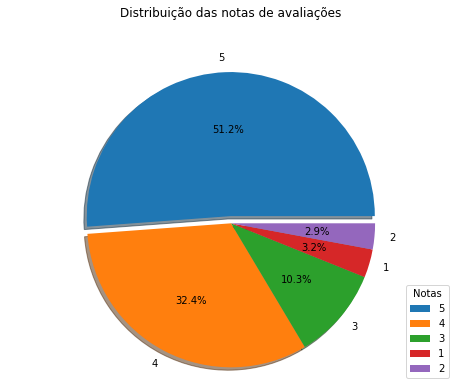

In [245]:
labels = df['ratingValue'].unique()
rating_percent = df['ratingValue'].value_counts(normalize=True) * 100
explode = (0.05, 0, 0, 0, 0)

fig, ax = plt.subplots(figsize=(8,6))
ax.pie(rating_percent, explode=explode, labels=labels, autopct='%1.1f%%',
        shadow=True)
ax.axis('equal')

plt.title('Distribuição das notas de avaliações', pad=40)
ax.legend(labels, loc='lower right', title='Notas')

plt.show()

A avaliação com nota 5 possui a maior frequência dentro do conjunto de dados, enquanto a com nota 2 são as menos frequentes. Dado o gráfico, é possível afirmar que os dados estão desbalanceados pois 51.2% deste conjunto de dados pertencem à avaliação com nota 5, enquanto as outras quatros notas juntas representam o restante dos dados.





## Distribuição das avaliações por diferentes dispositivos

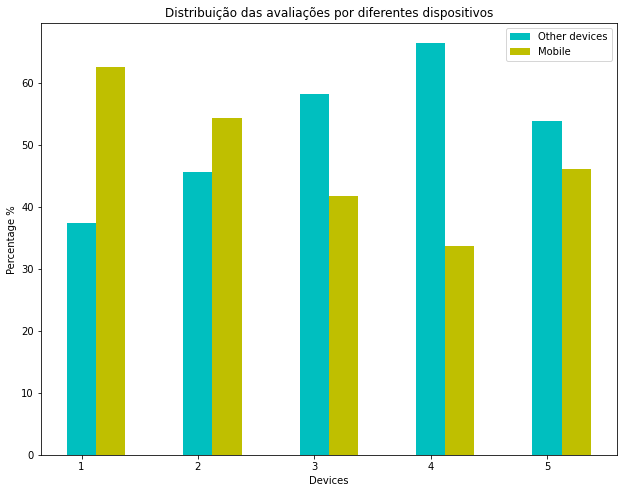

In [231]:
def get_rating_value_devices():
  devices = []
  for i in range (1,6):
    devices.append(df[df['ratingValue'] == str(i)]['mobileDevice'].value_counts(normalize=True, sort=False) * 100)
  return devices

devices = get_rating_value_devices() 

fig = plt.figure(figsize=(8,6))
ax = fig.add_axes([0,0,1,1])

X = np.arange(1,6)
ax.bar(X, [device[0] for device in devices], color='c', width = 0.25)
ax.bar(X+0.25, [device[1] for device in devices], color='y', width = 0.25)

plt.xlabel('Devices')
plt.ylabel('Percentage %')
plt.title('Distribuição das avaliações por diferentes dispositivos')
plt.legend(['Other devices', 'Mobile'])

plt.show()

Através do gráfico de barras acima, percebe-se que existe uma diferença de frequência entre dispositivos em relação as notas das avaliações. As notas de avaliações **1** e **2**, possuem as menores frequências de críticas realizadas em outros dispositivos e as maiores frequências realizadas em mobile, pode-se concluir que pessoas insatisfeitas com o restaurante, em sua maioria, possuem o interesse de realizar a crítica o quanto antes, dado isso a plataforma mais acessível seria a mobile.

## Distribuição de sentenças e palavras por comentários

In [287]:
def mean_sentences_words():
  
  df['reviewBody_TB'] = [TextBlob(comment) for comment in df['reviewBody']]

  mean_sentences = np.mean([len(comment.sentences) for comment in df['reviewBody_TB']])
  mean_words = np.mean([len(comment.word_counts) for comment in df['reviewBody_TB']])

  return [mean_sentences, mean_words]

In [289]:
mean_reviews = mean_sentences_words()

print("Média de sentenças por comentários: {:.2f}.\n" \
      "Média de palavras por comentários: {:.2f}.".format(mean_reviews[0],
                                                     mean_reviews[1]))

Média de sentenças por comentários: 3.63.
Média de palavras por comentários: 34.67.
